# mhwpype OISSTv2 Example

`mhwpype` at minimum accepts datasets with a time dimension and up through datasets with the dimensions of time, latitude, longitude, and depth.
For multi-dimensional datasets, the identification and characterization of marine heatwaves is done for each unique "cell" in the dataset. 
In all cases, the input dimensions should be the same as the output dimensions.


In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr

from mhwpype.fixed import Hobday16
from mhwpype.utils import assign_depth, reformat_longitude, update_names

## Load and Split Data
In this example, we use previously downloaded and aggregated NOAA OISSTv2 data. The file contains daily sea surface temperature from 1981 to 2025 and has the same structure one would see in a single annual OISSTv2 file downloaded directly from the OISSTv2 repository.

For this specific example, we will use data from 1983-01-01 to 2012-12-31 (30 years) as the fixed reference period and will detect marine heatwaves that occurred in 2019 for the OISSTv2 that occurs between 41.5 to 46.5N and -130 to -122 E.

`mhwpype` does not require that data have the specifically named coordinates of latitude, longitude, and depth but it is recommended. The only required dimension name is "time". If your data does not have an assigned depth, you can use the `assign_depth` utils function to add a depth coordinate to your data. In this example, we will assign a depth of 0 meters to the data. 


### Outline of Preprocessing Steps
1. Import total dataset.
2. Rename coordinates and variables. This is not required but is recommended. Since we will later assign depth, the variable name "sst" no longer makes sense.
3. Reformat longitude. This is not required but is recommended.
4. Slice the dataset by latitude and longitude for region of interst.
5. Assign dataset a depth coordinate. This is not required but recommended.
6. Split the total dataset into a reference dataset (ref) and an analysis dataset (dsy).


In [2]:
filepath = 'data/sst.day.mean.1981-2024.nc'
ds = xr.open_dataset(filepath)
ds = update_names(ds)
ds = reformat_longitude(ds)
ds = ds.sel(latitude= slice(41.5,46.5), longitude=slice(-130,-122))  
ds = assign_depth(ds, 0)

ref = ds.sel(time=slice(datetime(1983, 1, 1, 0, 0, 0), datetime(2012, 12, 31, 23, 59, 59)))  # 1983-2022
dsy = ds.sel(time=slice(datetime(2018, 12, 1, 0, 0, 0), datetime(2020, 1, 31, 23, 59, 59)))  # 2019
da = dsy.sea_water_temperature

## Instantiate a Marine Heatwave Identifier Class
`mhwpype` currently only supports fixed baseline analysis of marine heatwaves. The most commonly adhered fixed baseline methodology originates from Hobday et al. (2016). 
 Unless modified by you (the user) the `Hobday16` class functions are instantiated with the recommended settings for identification.

In [3]:
%%time
FixedBaseline = Hobday16()

CPU times: total: 0 ns
Wall time: 0 ns


## Build Climatology and Thresholds

Hobday et al. (2016) recommend using a reference period of 30 years. In creating the climatology and reference percentiles, they recommend using a centered rolling mean with a half-width of 5 days (window size of 11 days). For the reference percentiles, `mhwpype` calculates the percentile using linear interpolation, but any method strings can be used as described by xarray's [`quantile`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.quantile.html) function.

`mhwpype` first groups the input data by the julian day of the year (1-366). In smoothing the climatology and threshold percentiles, the data are stacked so that smoothing becomes "circular" between the end and beginning of the daily climatology/threshold dataset.

In the code cell below, we specify more than one percentile to calculate MHW statistics on.

In [4]:
%%time
cds = FixedBaseline.build_daily_climatology(ref.sea_water_temperature)
cda = cds.sea_water_temperature  # Climatology temperature data array. 

threshold = [0.9,0.95,0.99]  # Use the 90th, 95th, and 99th percentiles as thresholds.
pds = FixedBaseline.build_daily_threshold(ref.sea_water_temperature, threshold_value = threshold)
pda = pds.sea_water_temperature

CPU times: total: 9.5 s
Wall time: 9.58 s


## Build a MHW Mask

1. Unique cells are assigned a binary mask if the daily temperature value exceeds the percentile threshold for a given day. 
2. A rolling window is constructed, equal to the minimum number of days used to identify a marine heatwave (in this case 5 days). The last day in the window is assigned a binary value based on the sum of the window and its equivalency the minimum number of required days. 
3. A shift if performed to infill the start of each marine heatwave.
4. Gaps between "events" are patched if they fall within the minimum required gap condition (in this case 2 days). 

In [5]:
%%time
mhw_mask = FixedBaseline.build_mhw_mask(da, pda)

CPU times: total: 5.55 s
Wall time: 5.54 s


In [6]:
mhw_mask

<xarray.DataArray 'sea_water_temperature' (depth: 1, latitude: 20,
                                           longitude: 32, quantile: 3, time: 427)> Size: 7MB
array([[[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         ...,

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
...
          [0, 1, 1, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 1, 1, ..., 0, 0, 0],
          [0, 0, 1, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         ...,

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]]], shape=(1, 20, 32, 3, 427))
Coordinates:
  * depth      (depth) int64 8B 0
  * time       (time) datetime64[ns] 3kB 2018-12-01 2018-12-02 ... 2020-01-31
  * latitude   (latitude) float32 80B 41.62 41.88 42.12 ... 45.88 46.12 46.38
  * longitude  (longitude) float32 128B -129.9 -129.6 -129.4 ... -122.4 -122.1
  * quantile   (quantile) float64 24B 0.9 0.95 0.99

## Group MHWs
Using the MHW mask, events are group in each unique cell and the start date, stop date, and duration are provided. Within the mhw_groups dataset, the start date of the MHW event is used as the identifier.

In [7]:
%%time
mhw_groups = FixedBaseline.group_from_mask(mhw_mask) 

CPU times: total: 19.2 s
Wall time: 19.3 s


In [8]:
mhw_groups

<xarray.Dataset> Size: 208MB
Dimensions:         (depth: 1, latitude: 20, longitude: 25, quantile: 3,
                     event_id: 5777)
Coordinates:
  * depth           (depth) int64 8B 0
  * latitude        (latitude) float32 80B 41.62 41.88 42.12 ... 46.12 46.38
  * longitude       (longitude) float32 100B -129.9 -129.6 ... -124.1 -123.9
  * quantile        (quantile) float64 24B 0.9 0.95 0.99
  * event_id        (event_id) datetime64[ns] 46kB 2018-12-01 ... 2020-01-23
Data variables:
    event_start     (depth, latitude, longitude, quantile, event_id) datetime64[ns] 69MB ...
    event_end       (depth, latitude, longitude, quantile, event_id) datetime64[ns] 69MB ...
    event_duration  (depth, latitude, longitude, quantile, event_id) float64 69MB ...

## Calculate MHW Stats
After MHWs are grouped, scalar statistics are computed for each unique cell.

In [9]:
%%time
mhw_stats = FixedBaseline.group_stats(da, cda, pda, mhw_groups)

CPU times: total: 2min
Wall time: 2min 1s


In [10]:
mhw_stats

<xarray.Dataset> Size: 28MB
Dimensions:                                (event_id: 233, depth: 1,
                                            latitude: 20, longitude: 25,
                                            quantile: 3)
Coordinates:
  * depth                                  (depth) int64 8B 0
  * event_id                               (event_id) datetime64[ns] 2kB 2018...
  * latitude                               (latitude) float32 80B 41.62 ... 4...
  * longitude                              (longitude) float32 100B -129.9 .....
  * quantile                               (quantile) float64 24B 0.9 0.95 0.99
Data variables:
    event_start                            (event_id, depth, latitude, longitude, quantile) datetime64[ns] 3MB ...
    event_end                              (event_id, depth, latitude, longitude, quantile) datetime64[ns] 3MB ...
    event_duration                         (event_id, depth, latitude, longitude, quantile) float64 3MB ...
    event_peak_sea_water_temperature       (event_id, depth, latitude, longitude, quantile) float64 3MB ...
    event_peak_sea_water_temperature_time  (event_id, depth, latitude, longitude, quantile) datetime64[ns] 3MB ...
    event_peak_anomaly                     (event_id, depth, latitude, longitude, quantile) float64 3MB ...
    event_peak_anomaly_time                (event_id, depth, latitude, longitude, quantile) datetime64[ns] 3MB ...
    event_intensity_max                    (quantile, event_id, depth, latitude, longitude) float32 1MB ...
    event_intensity_mean                   (quantile, event_id, depth, latitude, longitude) float32 1MB ...
    event_intensity_stdev                  (quantile, event_id, depth, latitude, longitude) float32 1MB ...
    event_intensity_cumulative             (quantile, event_id, depth, latitude, longitude) float32 1MB ...
    event_peak_category                    (event_id, depth, latitude, longitude, quantile) float64 3MB ...

## Usage Examples

### Cell Time Series

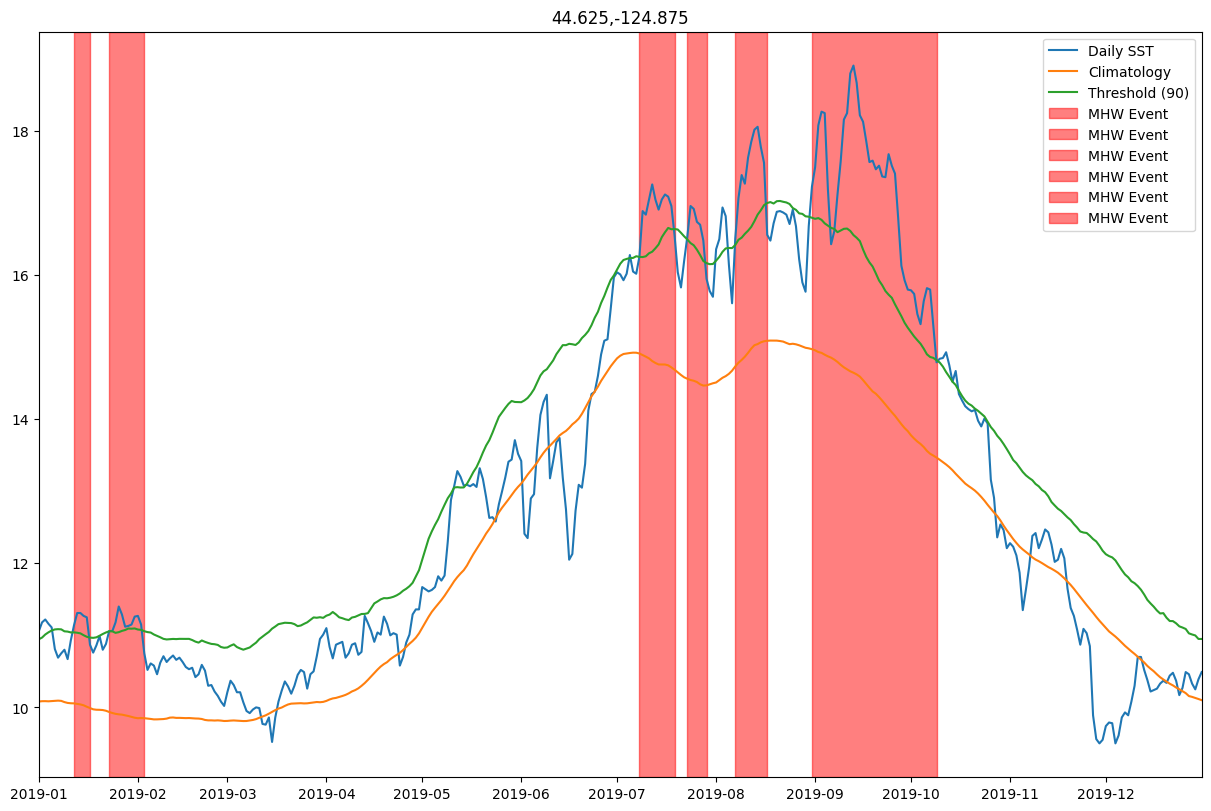

In [11]:
ds = mhw_stats.sel(depth = 0, quantile = 0.9, latitude = 44.5, longitude = -124.8, method = 'nearest')
ds = ds.sel(event_id = slice(datetime(2019,1,1), datetime(2019,12,31,23,59,59)))
ds = ds.dropna(dim = 'event_id')


yda = da.sel(depth = 0, latitude = 44.5, longitude = -124.8, method = 'nearest')
yda = yda.sel(time = slice(datetime(2019,1,1), datetime(2019,12,31,23,59,59)))

ycda = cda.sel(depth = 0, latitude = 44.5, longitude = -124.8, method = 'nearest')
ycda = ycda.sel(dayofyear = yda.time.dt.dayofyear)

ypda = pda.sel(depth = 0, quantile = 0.9, latitude = 44.5, longitude = -124.8, method = 'nearest')
ypda = ypda.sel(dayofyear = yda.time.dt.dayofyear)

fig, ax = plt.subplots(1,1, figsize = (12,8), constrained_layout = True)
ax.plot(yda.time, yda, label = 'Daily SST')
ax.plot(ycda.time, ycda, label = 'Climatology')
ax.plot(ypda.time, ypda, label = 'Threshold (90)')

for event_id in ds.event_id:
    _ds = ds.sel(event_id = event_id)
    ax.axvspan(_ds.event_start.values, _ds.event_end.values, color = 'red', alpha = 0.5, label = 'MHW Event', zorder = 0)


ax.set_xlim(yda.time.min(), yda.time.max())

ax.set_title(f"{yda.latitude.values},{yda.longitude.values}")
ax.legend(loc = 'upper right')

### Map of MHW Days in 2019

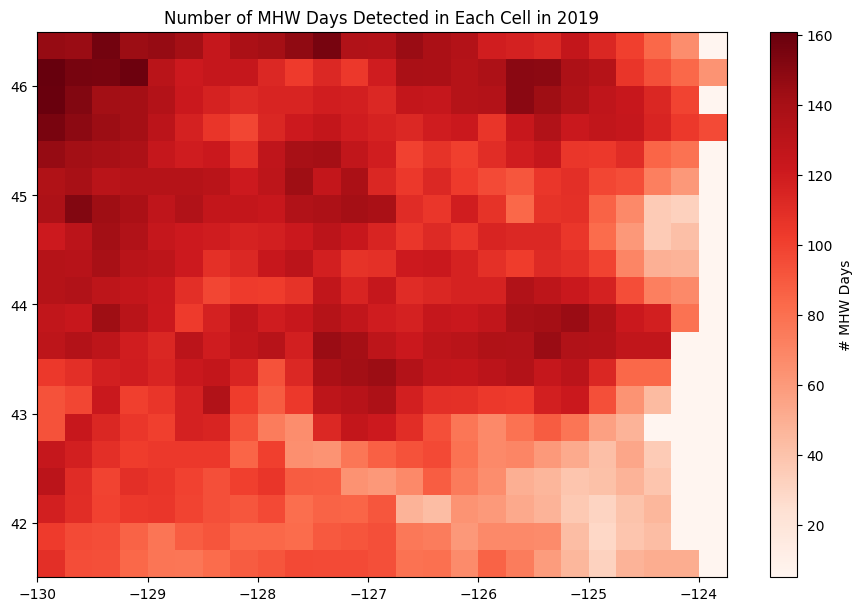

In [12]:
ds = mhw_stats.sel(depth = 0, quantile = 0.9, event_id = slice(datetime(2019,1,1), datetime(2019,12,31,23,59,59)))
duration = ds.event_duration.sum(dim='event_id')

fig, ax = plt.subplots(1,1, figsize=(10, 6), constrained_layout = True)

p = ax.pcolormesh(duration.longitude, duration.latitude, duration,cmap = 'Reds', vmin = 5)
fig.colorbar(p, ax = ax, label = '# MHW Days')
ax.set_title(f"Number of MHW Days Detected in Each Cell in 2019")

ax.set_box_aspect(abs((duration.latitude.max()-duration.latitude.min())/(duration.longitude.min()-duration.longitude.max())))
ax.set_facecolor('lightgrey')